In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from numpy import dot
from numpy.linalg import norm

In [3]:
from matplotlib import cm
from matplotlib.colors import Normalize

In [4]:
import io
from zipfile import ZipFile

## Read in pretrained word vectors

“wiki-news-300d-1M-subword.vec.zip: 1 million word vectors trained with subword infomation on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).”

Downloaded from https://fasttext.cc/

In [5]:
word_vector_zip = "../data/wiki-news-300d-1M-subword.vec.zip"

In [6]:
zf = ZipFile(word_vector_zip)
zf.namelist()

['wiki-news-300d-1M-subword.vec']

We'll read word vectors into a numpy ndarray and index into the array using a dict called `keys` where `keys[token]` is the row index of the word vector for `token`.

In [7]:
%%time

with ZipFile(word_vector_zip) as zf:
    with io.TextIOWrapper(zf.open('wiki-news-300d-1M-subword.vec'), encoding="utf-8") as f:
        n, d = map(int, f.readline().split())
        word_vecs = np.empty((n,d))
        keys = {}
        for i, line in enumerate(f):
            k, v = line.rstrip().split(" ", 1)
            for j, el in enumerate(v.split(" ")):
                word_vecs[i,j] = el
                keys[k] = i

print(word_vecs.shape)

(999994, 300)
CPU times: user 2min 16s, sys: 1.64 s, total: 2min 17s
Wall time: 2min 17s


## Similarity

Compare words and (to some extent) whole sentences by cosine similarity.

In [8]:
def sentence_to_vec(sentence):
    return sum(word_vecs[keys[token], :] for token in sentence.split(" "))

In [9]:
def cosine_similarity(a, b):
    return dot(a, b)/(norm(a)*norm(b))

In [10]:
def word_similarity(a, b):
    return cosine_similarity(word_vecs[keys[a],:], word_vecs[keys[b],:])

In [11]:
def sentence_similarity(a, b):
    return cosine_similarity(sentence_to_vec(a), sentence_to_vec(b))

In [12]:
sentence_similarity("I like chocolate ice cream", "I like chocolate chip mint ice cream")

0.9477107693452849

In [13]:
sentence_similarity("I like chocolate ice cream", "The cat ate my ice cream")

0.5146442787243557

These were the two least similar sentences I could think of. I was surprised their cosine similarity was as high as it is.

In [14]:
sentence_similarity(
    "I like chocolate ice cream",
    "The long barbed steel goblets were lifted and to cries and maledictions against the white whale the spirits were simultaneously quaffed down with a hiss"
)

0.4648821481672841

In [15]:
sentence_similarity(
    "I like chocolate ice cream",
    "White whales lifted steal goblets"
)

0.3248329082621558

In [16]:
word_similarity("run", "running")

0.8197941007772409

## Gender bias

Inspired by the paper “Exploring and Mitigating Gender Bias in GloVe Word Embeddings” by M.F. Vera (2018) we plot gender alignment of some words chosen to show that baked into word vectors, we can find influence of stereotypes.

In [17]:
def maleness(token):
    return sum(word_similarity(w, token) for w in ('he', 'him', 'man', 'male')) / 4

In [18]:
def femaleness(token):
    return sum(word_similarity(w, token) for w in ('she', 'her', 'woman', 'female')) / 4

In [19]:
def gender(token):
    return sum(word_similarity(w, token) for w in ('he', 'him', 'man', 'male')) \
         / sum(word_similarity(w, token) for w in ('she', 'her', 'woman', 'female'))

In [20]:
sum(gender(w) for w in keys) / len(word_vecs)

1.0564742224791321

In [21]:
words = [
    'boss', 'leader', 'follower', 'captain', 'nanny', 'hairdresser', 'stylist', 'receptionist', 'librarian', 'model',
    'nurse', 'doctor', 'scientist', 'researcher', 'assistant', 'programmer', 'developer', 'engineer', 'designer', 'bossy',
    'actor', 'actress', 'king', 'queen', 'aunt', 'uncle'
]

In [22]:
x = np.array([maleness(w) for w in words])
y = np.array([femaleness(w) for w in words])

In [23]:
x.shape, y.shape

((26,), (26,))

In [24]:
np.min(y/x), np.max(y/x)

(0.8427840581789612, 1.33992047361783)

In [25]:
cmap = cm.get_cmap('cool', 20)
cmap_norm = Normalize(vmin=0.5,vmax=1.5)

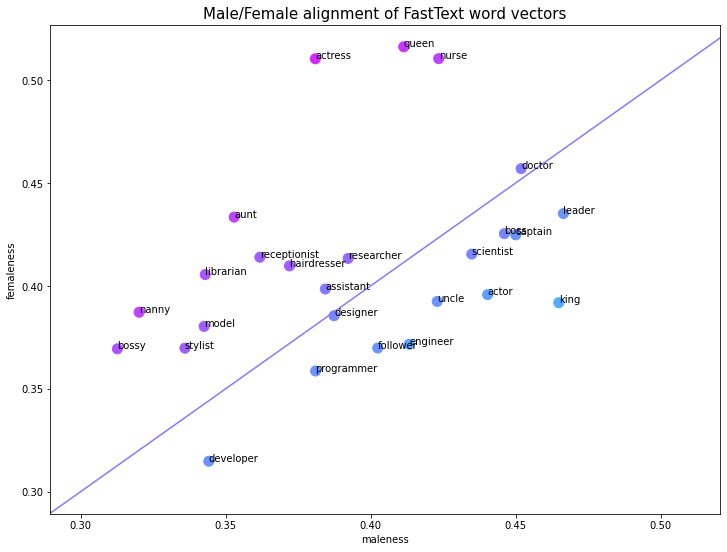

In [26]:
plt.figure(figsize=(12,9))
plt.scatter(x,y, color=[cmap(cmap_norm(yi/xi)) for xi,yi in zip(x,y)], s=100)
plt.axline((0.3, 0.3), (0.51, 0.51), color=cmap(cmap_norm(1)))
plt.xlabel("maleness")
plt.ylabel("femaleness")
plt.title("Male/Female alignment of FastText word vectors", fontsize=15)
for i, label in enumerate(words):
    plt.annotate(label, (x[i], y[i]))

plt.show()